In [ ]:
from datasets import load_dataset
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    get_scheduler,
    AutoModelForMultipleChoice,
    AutoConfig,
)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm


In [ ]:

# Load the MedQA dataset (US version)
dataset = load_dataset("VodLM/medqa", "us")

# Check available splits
print(dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

medqa.py:   0%|          | 0.00/5.45k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/7.69M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/964k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/997k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10178 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1272 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1273 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'uid', 'question', 'metamap', 'target', 'answers'],
        num_rows: 10178
    })
    validation: Dataset({
        features: ['idx', 'uid', 'question', 'metamap', 'target', 'answers'],
        num_rows: 1272
    })
    test: Dataset({
        features: ['idx', 'uid', 'question', 'metamap', 'target', 'answers'],
        num_rows: 1273
    })
})


In [ ]:

# Convert dataset to pandas DataFrame
train_data = dataset["train"].to_pandas()
test_data = dataset["test"].to_pandas()
validation_data = dataset["validation"].to_pandas()




In [ ]:
train_data.head()

,idx,uid,question,metamap,target,answers
0,0,train-0,A 23-year-old pregnant woman at 22 weeks gesta...,23 year old pregnant woman weeks presents burn...,3,"[Ampicillin, Ceftriaxone, Doxycycline, Nitrofu..."
1,1,train-1,A 3-month-old baby died suddenly at night whil...,3 month old baby died night asleep mother died...,0,[Placing the infant in a supine position on a ...
2,2,train-2,A mother brings her 3-week-old infant to the p...,mother week old infant pediatrician's office c...,0,"[Abnormal migration of ventral pancreatic bud,..."
3,3,train-3,A pulmonary autopsy specimen from a 58-year-ol...,pulmonary autopsy specimen 58 year old woman d...,0,"[Thromboembolism, Pulmonary ischemia, Pulmonar..."
4,4,train-4,A 20-year-old woman presents with menorrhagia ...,20 year old woman presents menorrhagia past ye...,3,"[Hemophilia A, Lupus anticoagulant, Protein C ..."


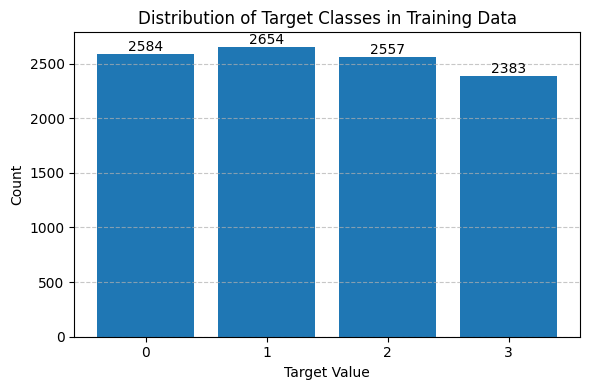

In [ ]:



# Count the occurrences of each target class
target_counts = train_data['target'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(target_counts.index.astype(str), target_counts.values)

# Add counts on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval),
             ha='center', va='bottom', fontsize=10)

# Labels and title
plt.title("Distribution of Target Classes in Training Data")
plt.xlabel("Target Value")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **Fully Fine Tuning BIOBERT**

In [ ]:
# Load BioBERT model and tokenizer
biobert_model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(biobert_model_name)
model = AutoModelForMultipleChoice.from_pretrained(biobert_model_name)


def encode_batch(questions, options_list):
    input_pairs = []
    for question, options in zip(questions, options_list):
        # Modified to create a list of strings instead of nested lists
        input_pairs.extend([[question, opt] for opt in options])
    # Tokenize all at once
    batch_encoding = tokenizer(input_pairs, padding=True, truncation=True, return_tensors="pt", max_length=128)
    # Reshape for multiple-choice format
    batch_size = len(questions)
    num_choices = len(options_list[0])  # Assuming all have the same number of choices
    # Reshaping logic remains the same
    batch_encoding = {k: v.view(batch_size, num_choices, -1) for k, v in batch_encoding.items()}
    return batch_encoding

def prepare_dataset(df):
    questions = df['question'].tolist()
    options_list = df['answers'].tolist()
    labels = df['target'].tolist()  # The correct answer index (1-based)

    encoded_inputs = encode_batch(questions, options_list)
    # Convert labels to 0-based indices
    #labels = [label for label in labels]
    # return torch.utils.data.TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'], torch.tensor(labels))
    dataset = []
    for i in range(len(labels)):
        dataset.append({
            'input_ids': encoded_inputs['input_ids'][i],
            'attention_mask': encoded_inputs['attention_mask'][i],
            'labels': torch.tensor(labels[i])
        })
    return dataset

# Prepare train and test datasets
train_dataset = prepare_dataset(train_data)
validation_dataset = prepare_dataset(validation_data)



from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",              # output directory
    eval_strategy="epoch",               # Use eval_strategy instead of evaluation_strategy
    learning_rate=2e-5,                  # learning rate
    per_device_train_batch_size=8,       # batch size for training
    per_device_eval_batch_size=16,       # batch size for evaluation
    num_train_epochs=3,                  # number of training epochs
    weight_decay=0.01,                   # strength of weight decay
    logging_dir="./logs",                # directory for storing logs
    logging_steps=10,
    run_name="bio-bert-finetune",         # Unique run name for this training
    report_to ='none'
)

trainer = Trainer(
    model=model,                       # the model to train
    args=training_args,                # training arguments
    train_dataset=train_dataset,       # training dataset
    eval_dataset=validation_dataset,         # evaluation dataset
)

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Start training
trainer.train()

# Evaluate the model
results = trainer.evaluate()

print("Evaluation results:", results)

Epoch,Training Loss,Validation Loss
1,1.399800,1.372479
2,1.338400,1.386541
3,1.236700,1.469527


Evaluation results: {'eval_loss': 1.4695265293121338, 'eval_runtime': 7.0394, 'eval_samples_per_second': 180.698, 'eval_steps_per_second': 11.365, 'epoch': 3.0}


In [ ]:
def predict_answers(model, df):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the correct device

    questions = df['question'].tolist()
    options_list = df['answers'].tolist()

    # Tokenize the inputs
    encoded_inputs = encode_batch(questions, options_list)

    # Move all tensor inputs to the same device
    encoded_inputs = {k: v.to(device) for k, v in encoded_inputs.items()}

    with torch.no_grad():
        logits = model(**encoded_inputs).logits  # Get logits for each option
        predictions = torch.argmax(logits, dim=1).tolist()  # Get index of best option

    # Map predictions to the options
    df["Predicted Answer"] = [options[pred] for options, pred in zip(options_list, predictions)]
    return df


# #import torch
# torch.cuda.empty_cache()

# Predict answers on the test set
test_predictions = predict_answers(model, test_data)

In [ ]:
test_predictions = [opts.tolist().index(ans) for opts, ans in zip(test_data['answers'].tolist(), test_predictions['Predicted Answer'].tolist())]

In [ ]:
from sklearn.metrics import accuracy_score
test_labels = [label for label in test_data['target'].tolist()]  # Convert to 0-based


accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.2820


In [ ]:
total_correct = sum([pred == true for pred, true in zip(test_predictions, test_labels)])
print(f"Total Correct Predictions: {total_correct} out of {len(test_labels)}")


Total Correct Predictions: 359 out of 1273


In [ ]:
#Classification Report
report = classification_report(test_labels, test_predictions, digits=4)
print("\nClassification Report (Fine Tuned BIOBERT):")
print(report)


Classification Report (Fine Tuned BIOBERT):
              precision    recall  f1-score   support

           0     0.3257    0.2805    0.3014       353
           1     0.2610    0.2686    0.2648       309
           2     0.3084    0.2977    0.3029       346
           3     0.2334    0.2792    0.2543       265

    accuracy                         0.2820      1273
   macro avg     0.2821    0.2815    0.2808      1273
weighted avg     0.2861    0.2820    0.2831      1273



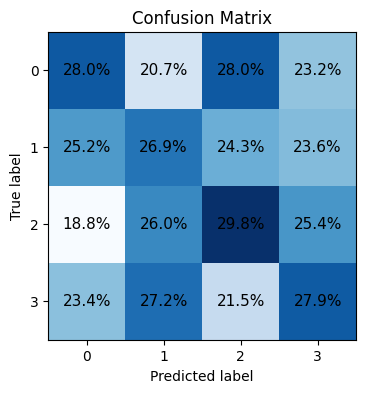

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Convert to percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot without text
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent)
disp.plot(cmap='Blues', ax=ax, colorbar=False, values_format=None)  # 👈 No auto labels

# Clear previous auto-labels
for text in ax.texts:
    text.set_text("")

# Add custom percentage labels with % symbol
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        value = cm_percent[i, j]
        ax.text(j, i, f"{value:.1f}%", ha='center', va='center', color='black', fontsize=11)

plt.title("Confusion Matrix")
plt.show()


# **Fine Tuning Freezed BIOBERT Model**

In [ ]:
# Load BioBERT model and tokenizer
biobert_model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(biobert_model_name)
model = AutoModelForMultipleChoice.from_pretrained(biobert_model_name)

# Freeze transformer layers
for param in model.base_model.parameters():
    param.requires_grad = False

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define custom BioBERT model with an added classification head for multiple-choice
class BioBertForMultipleChoice(nn.Module):
    def __init__(self, model_name="dmis-lab/biobert-base-cased-v1.1", num_choices=4, dropout_rate=0.1, freeze_bert=True):
        super(BioBertForMultipleChoice, self).__init__()
        # Load configuration and base model
        self.config = AutoConfig.from_pretrained(model_name)
        self.bert = AutoModel.from_pretrained(model_name, config=self.config)

        # Freeze transformer layers if desired
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
            # Ensure all frozen parameters are contiguous in memory
            for name, param in self.bert.named_parameters():
                param.data = param.data.contiguous()

        # Define a dropout and linear layer as the classification head.
        # Define classification head with two linear layers
        self.dropout = nn.Dropout(dropout_rate)
        # First linear layer: transforms from hidden size to hidden size
        self.fc1 = nn.Linear(self.config.hidden_size, self.config.hidden_size)
        # Activation function (you can also try ReLU, Tanh, etc.)
        self.activation = nn.ReLU()
        # Second linear layer: transforms to a single logit per option
        self.classifier = nn.Linear(self.config.hidden_size, 1)

        self.num_choices = num_choices

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        batch_size, num_choices, seq_length = input_ids.size()
        # Flatten for processing
        flat_input_ids = input_ids.view(batch_size * num_choices, seq_length)
        flat_attention_mask = attention_mask.view(batch_size * num_choices, seq_length)
        if token_type_ids is not None:
            flat_token_type_ids = token_type_ids.view(batch_size * num_choices, seq_length)
        else:
            flat_token_type_ids = None

        # Forward pass through BioBERT
        outputs = self.bert(input_ids=flat_input_ids,
                            attention_mask=flat_attention_mask,
                            token_type_ids=flat_token_type_ids)
        # Get the pooled [CLS] token output
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        logits = logits.view(batch_size, num_choices)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return {"loss": loss, "logits": logits}

# Use the BioBERT tokenizer (this is the correct one for BioBERT)
biobert_model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(biobert_model_name)

# Instantiate the custom model with frozen BioBERT layers and a custom classification head
model = BioBertForMultipleChoice(
    model_name=biobert_model_name,
    num_choices=4,
    dropout_rate=0.3,
    freeze_bert=True  # transformer layers are frozen and made contiguous inside the model
)

# Helper function to encode (question, option) pairs into the proper format
def encode_batch(questions, options_list, max_length=256):
    input_pairs = []
    for question, options in zip(questions, options_list):
        for option in options:
            input_pairs.append([question, option])
    batch_encoding = tokenizer(
        text=[pair[0] for pair in input_pairs],
        text_pair=[pair[1] for pair in input_pairs],
        padding="max_length",    # ensures uniform length
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    batch_size = len(questions)
    num_choices = len(options_list[0])
    batch_encoding = {k: v.view(batch_size, num_choices, -1) for k, v in batch_encoding.items()}
    return batch_encoding

# Function to prepare dataset from a pandas DataFrame.
def prepare_dataset(df):
    questions = df['question'].tolist()
    options_list = df['answers'].tolist()  # Each row should be a list of option strings.
    labels = df['target'].tolist()  # Labels should be 0-based indices.

    encoded_inputs = encode_batch(questions, options_list)
    dataset = []
    for i in range(len(labels)):
        dataset.append({
            'input_ids': encoded_inputs['input_ids'][i],
            'attention_mask': encoded_inputs['attention_mask'][i],
            'labels': torch.tensor(labels[i])
        })
    return dataset


train_dataset = prepare_dataset(train_data)
validation_dataset = prepare_dataset(validation_data)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",              # Directory to save model checkpoints and predictions.
    eval_strategy="epoch",               # Evaluation performed at the end of each epoch.
    learning_rate=0.1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    run_name="bio-bert-finetune",
    report_to='none'
)

# Create the Trainer with the custom model and prepared datasets.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

# Start training.
trainer.train()



model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,3.707700,1.489292
2,3.566000,1.492363
3,2.872700,1.453410
4,3.096400,1.437383
5,2.907800,1.451876
6,2.846400,1.416874
7,2.608700,1.436035
8,2.597600,1.445566
9,2.605900,1.426841
10,2.110600,1.481465


TrainOutput(global_step=12740, training_loss=2.3748223938784756, metrics={'train_runtime': 2594.9016, 'train_samples_per_second': 78.446, 'train_steps_per_second': 4.91, 'total_flos': 0.0, 'train_loss': 2.3748223938784756, 'epoch': 20.0})

In [ ]:
# Evaluate the model
results = trainer.evaluate()

print("Evaluation results:", results)

Evaluation results: {'eval_loss': 1.3824251890182495, 'eval_runtime': 13.6571, 'eval_samples_per_second': 93.138, 'eval_steps_per_second': 5.858, 'epoch': 20.0}


In [ ]:
def predict_answers(model, df, batch_size=16, max_length=256):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the correct device

    questions = df['question'].tolist()
    options_list = df['answers'].tolist()
    num_examples = len(questions)

    predictions = []

    # Process in batches
    for start_idx in range(0, num_examples, batch_size):
        end_idx = min(start_idx + batch_size, num_examples)
        batch_questions = questions[start_idx:end_idx]
        batch_options_list = options_list[start_idx:end_idx]

        # Tokenize the current batch
        encoded_inputs = encode_batch(batch_questions, batch_options_list, max_length=max_length)

        # Move tensor inputs to the GPU
        encoded_inputs = {k: v.to(device) for k, v in encoded_inputs.items()}

        # Make predictions for this batch
        with torch.no_grad():
            logits = model(**encoded_inputs).get("logits")
            batch_preds = torch.argmax(logits, dim=1).tolist()
            predictions.extend(batch_preds)

        # Clear intermediate GPU memory if needed
        torch.cuda.empty_cache()

    # Map predictions to the actual answer options
    df["Predicted Answer"] = [options[pred] for options, pred in zip(options_list, predictions)]
    return df

# Predict answers on the test set using batching
test_predictions = predict_answers(model, test_data, batch_size=16)

In [ ]:
test_predictions = [opts.tolist().index(ans) for opts, ans in zip(test_data['answers'].tolist(), test_predictions['Predicted Answer'].tolist())]

In [ ]:

from sklearn.metrics import accuracy_score
test_labels = [label for label in test_data['target'].tolist()]  # Convert to 0-based


accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.2553


In [ ]:
total_correct = sum([pred == true for pred, true in zip(test_predictions, test_labels)])
print(f"Total Correct Predictions: {total_correct} out of {len(test_labels)}")

Total Correct Predictions: 325 out of 1273


In [ ]:
#Classification Report
report = classification_report(test_labels, test_predictions, digits=4)
print("\nClassification Report (Fully Freezed BIOBERT):")
print(report)


Classification Report (Fully Freezed BIOBERT):
              precision    recall  f1-score   support

           0     0.3007    0.2436    0.2692       353
           1     0.2543    0.2848    0.2687       309
           2     0.2549    0.2254    0.2393       346
           3     0.2179    0.2755    0.2433       265

    accuracy                         0.2553      1273
   macro avg     0.2570    0.2573    0.2551      1273
weighted avg     0.2598    0.2553    0.2555      1273



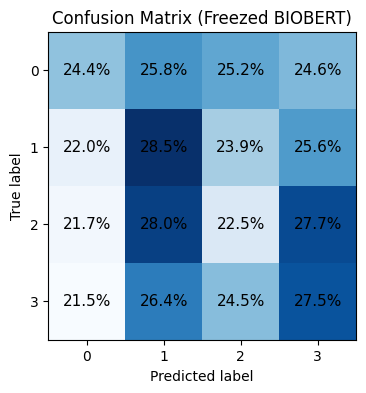

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Convert to percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot without text
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent)
disp.plot(cmap='Blues', ax=ax, colorbar=False, values_format=None)  # 👈 No auto labels

# Clear previous auto-labels
for text in ax.texts:
    text.set_text("")

# Add custom percentage labels with % symbol
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        value = cm_percent[i, j]
        ax.text(j, i, f"{value:.1f}%", ha='center', va='center', color='black', fontsize=11)

plt.title("Confusion Matrix (Freezed BIOBERT)")
plt.show()


# **Partial Freezing of Transformer Layers - BIOBERT**

In [ ]:
# 1. Load the tokenizer and model name
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# We'll use AutoModelForMultipleChoice to load a model ready for multiple choice tasks.
model = AutoModelForMultipleChoice.from_pretrained(model_name)

for param in model.bert.encoder.layer[:-2].parameters():
    param.requires_grad = False

# Optional: You could also freeze the pooler if desired:
for param in model.bert.pooler.parameters():
    param.requires_grad = False

# 2. Define a function to combine the raw question with the MetaMap output.
def combine_question_metamap(question, metamap, delimiter=" [META] "):
    return question + delimiter + metamap

# 3. Create a function to encode a batch of (question, option) pairs.
def encode_batch(questions, options_list, max_length=384):
    """
    For each combined question and its list of answer options,
    create (question, option) pairs, tokenize them, and reshape the result.
    """
    input_pairs = []
    for question, options in zip(questions, options_list):
        for option in options:
            input_pairs.append([question, option])

    # Tokenize the list of pairs.
    tokenized = tokenizer(
        text=[pair[0] for pair in input_pairs],
        text_pair=[pair[1] for pair in input_pairs],
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    # Reshape to the required format: (batch_size, num_choices, sequence_length)
    batch_size = len(questions)
    num_choices = len(options_list[0])
    tokenized = {k: v.view(batch_size, num_choices, -1) for k, v in tokenized.items()}
    return tokenized

# 4. Create a function to prepare the dataset from a pandas DataFrame.
def prepare_dataset_with_metamap(df, max_length=384):
    """
    Assumes df has columns:
      - 'question': Raw question text.
      - 'metamap': MetaMap preprocessed text.
      - 'answers': A list of answer options.
      - 'target': The correct answer index (0-based).

    We combine the question and metamap fields and then tokenize the (question, option) pairs.
    """
    # Combine question and metamap
    combined_questions = df.apply(lambda row: combine_question_metamap(row['question'], row['metamap']), axis=1).tolist()
    answers_list = df['answers'].tolist()  # Each row should be a list of answer strings.
    targets = df['target'].tolist()          # Correct answer index for each sample.

    # Tokenize the combined questions with their answer options.
    encoded_inputs = encode_batch(combined_questions, answers_list, max_length=max_length)

    # Prepare a dataset as a list of dictionaries.
    dataset = []
    for i in range(len(targets)):
        instance = {
            'input_ids': encoded_inputs['input_ids'][i],
            'attention_mask': encoded_inputs['attention_mask'][i],
            # Uncomment if your tokenizer/model produces token_type_ids:
            # 'token_type_ids': encoded_inputs.get('token_type_ids', None)[i],
            'labels': torch.tensor(targets[i])
        }
        dataset.append(instance)
    return dataset

train_dataset = prepare_dataset_with_metamap(train_data, max_length=384)
validation_dataset = prepare_dataset_with_metamap(validation_data, max_length=384)

# 6. Set up TrainingArguments using the Trainer API.
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    logging_steps=10,
    report_to="none"
)

# 7. Instantiate Trainer with our model, training arguments, and dataset.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

# 8. Fine-tune the model.
trainer.train()


Some weights of BertForMultipleChoice were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.379600,1.385933
2,1.387900,1.384503
3,1.384000,1.382226
4,1.389000,1.380895


TrainOutput(global_step=2548, training_loss=1.3873962334224157, metrics={'train_runtime': 1664.9637, 'train_samples_per_second': 24.452, 'train_steps_per_second': 1.53, 'total_flos': 3.213504332727091e+16, 'train_loss': 1.3873962334224157, 'epoch': 4.0})

In [ ]:
# Evaluate the model
results = trainer.evaluate()

print("Evaluation results:", results)

Evaluation results: {'eval_loss': 1.3808945417404175, 'eval_runtime': 20.7288, 'eval_samples_per_second': 61.364, 'eval_steps_per_second': 3.859, 'epoch': 4.0}


In [ ]:
import torch

def predict_answers(model, df, batch_size=16, max_length=256, delimiter=" [META] "):
    """
    Predict answers for a dataset using a model for multiple-choice questions,
    concatenating the raw question with its MetaMap output.

    Args:
      model: The fine-tuned model (e.g., AutoModelForMultipleChoice).
      df (pandas.DataFrame): DataFrame containing the columns 'question', 'metamap', and 'answers'.
      batch_size (int): Batch size for inference.
      max_length (int): Maximum token length for tokenization.
      delimiter (str): Delimiter to insert between the question and the MetaMap output.

    Returns:
      df: The original DataFrame with an extra column "Predicted Answer" containing the predicted answer string.
    """
    model.eval()  # set model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # move model to device

    # Combine raw question with MetaMap output using the specified delimiter.
    raw_questions = df['question'].tolist()
    metamap_texts = df['metamap'].tolist()
    combined_questions = [q + delimiter + m for q, m in zip(raw_questions, metamap_texts)]

    options_list = df['answers'].tolist()  # Each row: a list of answer options.
    num_examples = len(combined_questions)

    predictions = []

    # Process in batches
    for start_idx in range(0, num_examples, batch_size):
        end_idx = min(start_idx + batch_size, num_examples)
        batch_questions = combined_questions[start_idx:end_idx]
        batch_options_list = options_list[start_idx:end_idx]

        # Tokenize the current batch.
        encoded_inputs = encode_batch(batch_questions, batch_options_list, max_length=max_length)

        # Move tensor inputs to device.
        encoded_inputs = {k: v.to(device) for k, v in encoded_inputs.items()}

        # Make predictions for this batch.
        with torch.no_grad():
            outputs = model(**encoded_inputs)
            logits = outputs.get("logits")
            batch_preds = torch.argmax(logits, dim=1).tolist()
            predictions.extend(batch_preds)

        torch.cuda.empty_cache()  # clear intermediate GPU memory if needed

    # Map predicted indices to the answer options.
    df["Predicted Answer"] = [options[pred] for options, pred in zip(options_list, predictions)]

    return df


# Predict answers on the test set using batching
test_predictions = predict_answers(model, test_data, batch_size=16, max_length=256)
# Example usage:
# Assuming you have a test_data DataFrame with 'question', 'metamap', and 'answers' columns.
# test_predictions = predict_answers(model, test_data, batch_size=16, max_length=256)


In [ ]:
test_predictions = [opts.tolist().index(ans) for opts, ans in zip(test_data['answers'].tolist(), test_predictions['Predicted Answer'].tolist())]



In [ ]:

from sklearn.metrics import accuracy_score
test_labels = [label for label in test_data['target'].tolist()]  # Convert to 0-based


accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.2954


In [ ]:
total_correct = sum([pred == true for pred, true in zip(test_predictions, test_labels)])
print(f"Total Correct Predictions: {total_correct} out of {len(test_labels)}")

Total Correct Predictions: 376 out of 1273


In [ ]:
#Classification Report
report = classification_report(test_labels, test_predictions, digits=4)
print("\nClassification Report (Partial Freezed BIOBERT):")
print(report)


Classification Report (Partial Freezed BIOBERT):
              precision    recall  f1-score   support

           0     0.2839    0.2550    0.2687       353
           1     0.2862    0.2816    0.2838       309
           2     0.3617    0.3439    0.3526       346
           3     0.2477    0.3019    0.2721       265

    accuracy                         0.2954      1273
   macro avg     0.2949    0.2956    0.2943      1273
weighted avg     0.2981    0.2954    0.2959      1273



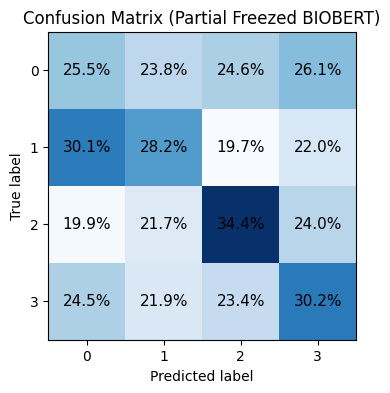

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Convert to percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot without text
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent)
disp.plot(cmap='Blues', ax=ax, colorbar=False, values_format=None)  # 👈 No auto labels

# Clear previous auto-labels
for text in ax.texts:
    text.set_text("")

# Add custom percentage labels with % symbol
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        value = cm_percent[i, j]
        ax.text(j, i, f"{value:.1f}%", ha='center', va='center', color='black', fontsize=11)

plt.title("Confusion Matrix (Partial Freezed BIOBERT)")
plt.show()


# **Fully fine-tuned BioGPT with classification head**

In [ ]:
model_name = "microsoft/BioGPT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"


from transformers import AutoModelForCausalLM

base_model = AutoModel.from_pretrained("microsoft/BioGPT")


# Define answer label map
LETTER_MAP = ["0", "1", "2", "3"]

def build_prompt(example):
    question = example["question"]
    options = example["answers"]
    prompt = (
        f"Question: {question}\n"
        "Options:\n"
        f"0: {options[0]}\n"
        f"1: {options[1]}\n"
        f"2: {options[2]}\n"
        f"3: {options[3]}\n"
        "And the Answer is:"
    )
    return prompt

class MedQADataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_length=600):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        prompt = build_prompt(example)
        tokenized = self.tokenizer(
            prompt,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        tokenized = {k: v.squeeze(0) for k, v in tokenized.items()}
        return {
            "input_ids": tokenized["input_ids"],
            "attention_mask": tokenized["attention_mask"],
            "labels": torch.tensor(example["target"], dtype=torch.long)
        }

# Your dataset (assumed loaded externally)
train_examples = train_data.to_dict(orient="records")
val_examples = validation_data.to_dict(orient="records")

train_dataset = MedQADataset(train_examples, tokenizer)
val_dataset = MedQADataset(val_examples, tokenizer)

class BioGPTClassifier(nn.Module):
    def __init__(self, base_model, hidden_size=1024, num_classes=4):
        super(BioGPTClassifier, self).__init__()
        self.base_model = base_model
        self.hidden_size = hidden_size
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        last_hidden_state = outputs.last_hidden_state  # shape: (batch_size, seq_len, hidden_size)
        # ✅ Mean pooling over non-padding tokens
        mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
        masked_hidden = last_hidden_state * mask
        sum_hidden = masked_hidden.sum(dim=1)
        lengths = mask.sum(dim=1).clamp(min=1e-9)
        pooled_output = sum_hidden / lengths

        logits = self.classifier(pooled_output)

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

model = BioGPTClassifier(base_model).to("cuda" if torch.cuda.is_available() else "cpu")

training_args = TrainingArguments(
    output_dir="./biogpt_medqa_effective",
    overwrite_output_dir=True,
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_accumulation_steps=4,
    gradient_accumulation_steps=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    logging_steps=50,
    report_to=[],
    save_total_limit=2,
    save_safetensors=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)


Epoch,Training Loss,Validation Loss
1,1.409400,1.410575
2,1.409800,1.418786
3,1.395000,1.410340
4,1.354000,1.438354
5,1.098700,1.735755
6,0.640600,2.489183
7,0.204700,3.577871


Evaluation results: {'eval_loss': 1.4103397130966187, 'eval_runtime': 9.9308, 'eval_samples_per_second': 128.087, 'eval_steps_per_second': 16.011, 'epoch': 7.977219167321288}


In [ ]:
# Evaluation report
predictions = trainer.predict(val_dataset)
logits = predictions.predictions
y_true = predictions.label_ids
y_pred = np.argmax(logits, axis=1)

# Total correct predictions
correct_predictions = np.sum(y_true == y_pred)
total_predictions = len(y_true)

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=LETTER_MAP))



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.02      0.04       330
           1       0.23      0.29      0.26       316
           2       0.30      0.35      0.32       352
           3       0.23      0.38      0.29       274

    accuracy                           0.26      1272
   macro avg       0.33      0.26      0.23      1272
weighted avg       0.33      0.26      0.22      1272



In [ ]:
print("\n✅ Accuracy:", accuracy_score(y_true, y_pred))
print(f"\n🎯 Total Correct Predictions: {correct_predictions} out of {total_predictions}")



✅ Accuracy: 0.2555031446540881

🎯 Total Correct Predictions: 325 out of 1272


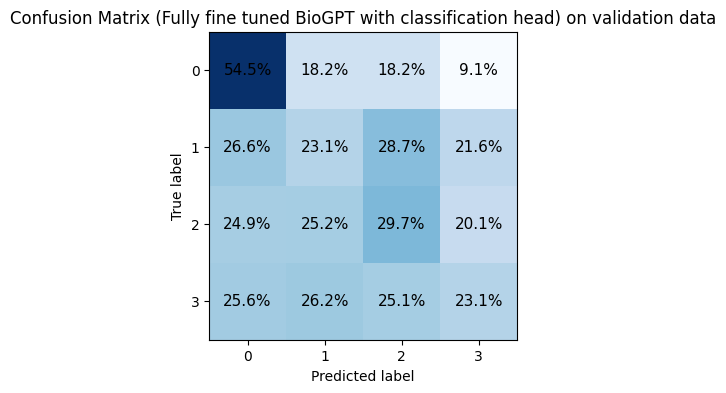

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate confusion matrix
cm = confusion_matrix(y_pred, y_true)

# Convert to percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot without text
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent)
disp.plot(cmap='Blues', ax=ax, colorbar=False, values_format=None)  # 👈 No auto labels

# Clear previous auto-labels
for text in ax.texts:
    text.set_text("")

# Add custom percentage labels with % symbol
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        value = cm_percent[i, j]
        ax.text(j, i, f"{value:.1f}%", ha='center', va='center', color='black', fontsize=11)

plt.title("Confusion Matrix (Fully fine tuned BioGPT with classification head) on validation data")
plt.show()


In [ ]:
test_examples = test_data.to_dict(orient="records")

test_dataset = MedQADataset(test_examples, tokenizer)

# Evaluation report
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
y_true = predictions.label_ids
y_pred = np.argmax(logits, axis=1)

# Total correct predictions
correct_predictions = np.sum(y_true == y_pred)
total_predictions = len(y_true)

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=LETTER_MAP))



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.01      0.01       353
           1       0.27      0.35      0.31       309
           2       0.29      0.35      0.31       346
           3       0.20      0.32      0.24       265

    accuracy                           0.25      1273
   macro avg       0.23      0.26      0.22      1273
weighted avg       0.23      0.25      0.21      1273



In [ ]:
print("\n✅ Accuracy:", accuracy_score(y_true, y_pred))
print(f"\n🎯 Total Correct Predictions: {correct_predictions} out of {total_predictions}")



✅ Accuracy: 0.24901806755695208

🎯 Total Correct Predictions: 317 out of 1273


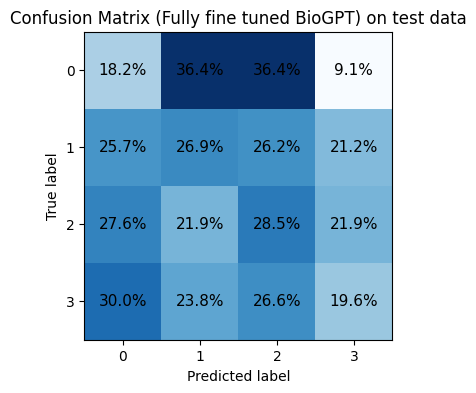

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate confusion matrix
cm = confusion_matrix(y_pred, y_true)

# Convert to percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot without text
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent)
disp.plot(cmap='Blues', ax=ax, colorbar=False, values_format=None)  # 👈 No auto labels

# Clear previous auto-labels
for text in ax.texts:
    text.set_text("")

# Add custom percentage labels with % symbol
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        value = cm_percent[i, j]
        ax.text(j, i, f"{value:.1f}%", ha='center', va='center', color='black', fontsize=11)

plt.title("Confusion Matrix (Fully fine tuned BioGPT) on test data")
plt.show()


# **Fully Fine tuned BioGPT for generative task**

In [ ]:

# Load BioGPT
model_name = "microsoft/BioGPT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device

LETTER_MAP = ["0", "1", "2", "3"]

# Prompt builder

def build_prompt(example):
    question = example["question"]
    options = example["answers"]
    prompt = (
        f"Question: {question}\n"
        f"Options:\n"
        f"0: {options[0]}\n"
        f"1: {options[1]}\n"
        f"2: {options[2]}\n"
        f"3: {options[3]}\n"
        f"Choose the best option (A, B, C, or D). Answer:"
    )
    return prompt, LETTER_MAP[example["target"]]

# Dataset
class QADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        prompt, answer = build_prompt(self.data[idx])
        input_text = prompt + " " + answer
        encoding = self.tokenizer(
            input_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        answer_token_ids = self.tokenizer(answer, add_special_tokens=False)["input_ids"]
        answer_start = len(input_ids) - len(answer_token_ids)

        labels = torch.full_like(input_ids, -100)
        labels[answer_start:] = torch.tensor(answer_token_ids)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }

# Example DataFrame loading (replace this with your actual data)
# train_data = pd.read_csv("train.csv")
# val_data = pd.read_csv("val.csv")
train_examples = train_data.to_dict(orient="records")
val_examples = validation_data.to_dict(orient="records")

train_dataset = QADataset(train_examples, tokenizer)
val_dataset = QADataset(val_examples, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 10)

# ... all imports and setup remain unchanged ...

# Training Loop
for epoch in range(1, 6):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch} - Training"):
        for k in batch:
            batch[k] = batch[k].to(device)

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Evaluation (Compute Validation Loss)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch} - Validation"):
            for k in batch:
                batch[k] = batch[k].to(device)
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")


Epoch 1 - Validation: 100%|██████████| 80/80 [00:33<00:00,  2.42it/s]


Epoch 1 | Train Loss: 1.4472 | Validation Loss: 1.3937


Epoch 2 - Validation: 100%|██████████| 80/80 [00:32<00:00,  2.42it/s]


Epoch 2 | Train Loss: 1.4039 | Validation Loss: 1.4085


Epoch 3 - Validation: 100%|██████████| 80/80 [00:32<00:00,  2.43it/s]


Epoch 3 | Train Loss: 1.3900 | Validation Loss: 1.4012


Epoch 4 - Validation: 100%|██████████| 80/80 [00:32<00:00,  2.43it/s]


Epoch 4 | Train Loss: 1.2892 | Validation Loss: 1.4965


Epoch 5 - Validation: 100%|██████████| 80/80 [00:32<00:00,  2.43it/s]

Epoch 5 | Train Loss: 0.8419 | Validation Loss: 1.9517


In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch


def extract_letter(generated_text):
    if "Answer:" in generated_text:
        _, _, answer_part = generated_text.partition("Answer:")
        answer_part = answer_part.strip()
        if answer_part in LETTER_MAP:
            return answer_part
    return ""
pred_answers = []
gold_answers = []  # You need to extract gold answers from your examples as well.
pred_texts_ = []

def evaluate_model_inference(dataset, model, tokenizer, batch_size=4):
    import torch
    from torch.utils.data import DataLoader
    from tqdm import tqdm

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    pred_answers = []
    gold_answers = []  # You need to extract gold answers from your examples as well.
    pred_texts_ = []

    # Define a collate function to build prompts on the fly using build_prompt
    def collate_fn(examples):
        # Generate prompt using your build_prompt function.
        prompts = [build_prompt(example)[0] for example in examples]
        tokenized_prompt = tokenizer(
            prompts,
            truncation=True,
            max_length=384,   # Adjust this max_length as needed
            padding="max_length",
            return_tensors="pt"
        )
        return tokenized_prompt

    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)



    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=1  # Adjust based on how many tokens you expect in the answer
            )

            pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            pred_texts_.extend(pred_texts)

            # Extract answer letters
            # Use an extraction function that gets the last token after "Answer:"
            for text in pred_texts:
                answer = extract_letter(text)
                pred_answers.append(answer)

    # For gold answers, you need to reconstruct them from your dataset. For example:
    for example in dataset:
        # Use build_prompt(example) to get the ground truth answer if needed,
        # Otherwise, if the original dict has a 'target' key:
        gold_answers.append(LETTER_MAP[example["target"]])

    # Calculate accuracy
    correct = sum([pred == gold for pred, gold in zip(pred_answers, gold_answers) if pred in LETTER_MAP])
    total = len(pred_answers)
    accuracy = correct / total if total > 0 else 0

    print(f"\n✅ Total correct predictions: {correct}/ {total}")
    print("✅ Accuracy:", round(accuracy * 100, 2), "%")
    print(classification_report(gold_answers, pred_answers, labels = LETTER_MAP))
    return accuracy


**Evaluation on validation data**

In [ ]:
val_results = evaluate_model_inference(val_examples, model, tokenizer)


Evaluating: 100%|██████████| 318/318 [00:34<00:00,  9.19it/s]


✅ Total correct predictions: 363/ 1272
✅ Accuracy: 28.54 %
              precision    recall  f1-score   support

           0       0.29      0.37      0.33       330
           1       0.25      0.40      0.31       316
           2       0.39      0.16      0.23       352
           3       0.31      0.21      0.25       274

   micro avg       0.29      0.29      0.29      1272
   macro avg       0.31      0.29      0.28      1272
weighted avg       0.31      0.29      0.28      1272



**Evaluation on test data**

In [ ]:
test_examples = test_data.to_dict(orient="records")
test_results = evaluate_model_inference(test_examples, model, tokenizer)


Evaluating: 100%|██████████| 319/319 [00:34<00:00,  9.23it/s]


✅ Total correct predictions: 408/ 1273
✅ Accuracy: 32.05 %
              precision    recall  f1-score   support

           0       0.34      0.44      0.38       353
           1       0.30      0.48      0.37       309
           2       0.40      0.17      0.24       346
           3       0.30      0.17      0.22       265

   micro avg       0.32      0.32      0.32      1273
   macro avg       0.33      0.32      0.30      1273
weighted avg       0.34      0.32      0.31      1273



# **Partial Freezing of BioGPT for Generative task with LM head**

In [ ]:

# Load BioGPT
model_name = "microsoft/BioGPT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device

# Access the internal BioGptModel
transformer_layers = model.biogpt.layers   # BioGPT uses this structure

# Freeze all but the top 4 transformer blocks
num_layers = len(transformer_layers)
for i, layer in enumerate(transformer_layers):
    if i < num_layers - 4:
        for param in layer.parameters():
            param.requires_grad = False


LETTER_MAP = ["0", "1", "2", "3"]

# Prompt builder

def build_prompt(example):
    question = example["question"]
    options = example["answers"]
    prompt = (
        f"Question: {question}\n"
        f"Options:\n"
        f"0: {options[0]}\n"
        f"1: {options[1]}\n"
        f"2: {options[2]}\n"
        f"3: {options[3]}\n"
        f"Choose the best option (A, B, C, or D). Answer:"
    )
    return prompt, LETTER_MAP[example["target"]]

# Dataset
class QADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        prompt, answer = build_prompt(self.data[idx])
        input_text = prompt + " " + answer
        encoding = self.tokenizer(
            input_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        answer_token_ids = self.tokenizer(answer, add_special_tokens=False)["input_ids"]
        answer_start = len(input_ids) - len(answer_token_ids)

        labels = torch.full_like(input_ids, -100)
        labels[answer_start:] = torch.tensor(answer_token_ids)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }

# Example DataFrame loading (replace this with your actual data)
# train_data = pd.read_csv("train.csv")
# val_data = pd.read_csv("val.csv")
train_examples = train_data.to_dict(orient="records")
val_examples = validation_data.to_dict(orient="records")

train_dataset = QADataset(train_examples, tokenizer)
val_dataset = QADataset(val_examples, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 10)

# ... all imports and setup remain unchanged ...

# Training Loop
for epoch in range(1, 6):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch} - Training"):
        for k in batch:
            batch[k] = batch[k].to(device)

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Evaluation (Compute Validation Loss)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch} - Validation"):
            for k in batch:
                batch[k] = batch[k].to(device)
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")


Epoch 1 - Validation: 100%|██████████| 80/80 [00:33<00:00,  2.42it/s]


Epoch 1 | Train Loss: 1.4593 | Validation Loss: 1.3967


Epoch 2 - Validation: 100%|██████████| 80/80 [00:33<00:00,  2.42it/s]


Epoch 2 | Train Loss: 1.4021 | Validation Loss: 1.3991


Epoch 3 - Validation: 100%|██████████| 80/80 [00:33<00:00,  2.42it/s]


Epoch 3 | Train Loss: 1.3892 | Validation Loss: 1.4124


Epoch 4 - Validation: 100%|██████████| 80/80 [00:33<00:00,  2.42it/s]


Epoch 4 | Train Loss: 1.3577 | Validation Loss: 1.4490


Epoch 5 - Validation: 100%|██████████| 80/80 [00:33<00:00,  2.42it/s]

Epoch 5 | Train Loss: 1.2997 | Validation Loss: 1.4921


In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch


def extract_letter(generated_text):
    if "Answer:" in generated_text:
        _, _, answer_part = generated_text.partition("Answer:")
        answer_part = answer_part.strip()
        if answer_part in LETTER_MAP:
            return answer_part
    return ""
pred_answers = []
gold_answers = []  # You need to extract gold answers from your examples as well.
pred_texts_ = []

def evaluate_model_inference(dataset, model, tokenizer, batch_size=4):
    import torch
    from torch.utils.data import DataLoader
    from tqdm import tqdm

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    pred_answers = []
    gold_answers = []  # You need to extract gold answers from your examples as well.
    pred_texts_ = []

    # Define a collate function to build prompts on the fly using build_prompt
    def collate_fn(examples):
        # Generate prompt using your build_prompt function.
        prompts = [build_prompt(example)[0] for example in examples]
        tokenized_prompt = tokenizer(
            prompts,
            truncation=True,
            max_length=384,   # Adjust this max_length as needed
            padding="max_length",
            return_tensors="pt"
        )
        return tokenized_prompt

    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)



    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=1  # Adjust based on how many tokens you expect in the answer
            )

            pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            pred_texts_.extend(pred_texts)

            # Extract answer letters
            # Use an extraction function that gets the last token after "Answer:"
            for text in pred_texts:
                answer = extract_letter(text)
                pred_answers.append(answer)

    # For gold answers, you need to reconstruct them from your dataset. For example:
    for example in dataset:
        # Use build_prompt(example) to get the ground truth answer if needed,
        # Otherwise, if the original dict has a 'target' key:
        gold_answers.append(LETTER_MAP[example["target"]])

    # Calculate accuracy
    correct = sum([pred == gold for pred, gold in zip(pred_answers, gold_answers) if pred in LETTER_MAP])
    total = len(pred_answers)
    accuracy = correct / total if total > 0 else 0

    print(f"\n✅ Total correct predictions: {correct}/ {total}")
    print("✅ Accuracy:", round(accuracy * 100, 2), "%")
    print(classification_report(gold_answers, pred_answers, labels = LETTER_MAP))
    return accuracy


In [ ]:
val_results = evaluate_model_inference(val_examples, model, tokenizer)


Evaluating: 100%|██████████| 318/318 [00:34<00:00,  9.25it/s]


✅ Total correct predictions: 336/ 1272
✅ Accuracy: 26.42 %
              precision    recall  f1-score   support

           0       0.24      0.08      0.13       330
           1       0.28      0.53      0.36       316
           2       0.28      0.26      0.27       352
           3       0.23      0.18      0.20       274

   micro avg       0.27      0.26      0.27      1272
   macro avg       0.26      0.26      0.24      1272
weighted avg       0.26      0.26      0.24      1272



In [ ]:

test_results = evaluate_model_inference(test_examples, model, tokenizer)


Evaluating: 100%|██████████| 319/319 [00:34<00:00,  9.23it/s]


✅ Total correct predictions: 323/ 1273
✅ Accuracy: 25.37 %
              precision    recall  f1-score   support

           0       0.33      0.14      0.19       353
           1       0.25      0.53      0.34       309
           2       0.26      0.20      0.23       346
           3       0.22      0.16      0.18       265

   micro avg       0.26      0.25      0.26      1273
   macro avg       0.27      0.26      0.24      1273
weighted avg       0.27      0.25      0.24      1273

